In [2]:
import os
import re
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import optimizers, datasets
from keras import Model
from keras import applications
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense

Using TensorFlow backend.


In [3]:
# seems to reduce the chance of gpu errors

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [4]:
batch_size = 64

In [16]:
datagen = ImageDataGenerator(rescale=1./255, 
                             validation_split=0.2)

if os.path.isdir('preview'):
    shutil.rmtree('preview')
os.makedirs('preview')
img = load_img('data/train/cat/204.png')
x = img_to_array(img)          # array with shape (3, 32, 32)
x = x.reshape((1,) + x.shape)  # array with shape (1, 3, 32, 32)

i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='png'):
    i += 1
    if i > 20:
        break

In [5]:
datagen_aug = ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2, 
                                 horizontal_flip=True,
                                 width_shift_range=3,
                                 height_shift_range=3)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)



train_generator = datagen_aug.flow_from_directory('data/train',
                                                    target_size=(32, 32),
                                                    batch_size=batch_size,
                                                    seed=0,
                                                    subset='training')

validation_generator = datagen.flow_from_directory('data/train',
                                                    target_size=(32, 32),
                                                    batch_size=batch_size,
                                                    seed=0,
                                                    subset='validation')

Found 40000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [109]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(4e-4), input_shape=(32, 32, 3)))
#model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(0.1))
model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(4e-4)))
#model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(4e-4)))
#model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(4e-4)))
#model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(4e-4)))
#model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(4e-4)))
#model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(4e-4)))
#model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(4e-4)))
#model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(0.4))
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(4e-4)))
#model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(0.4))
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(4e-4)))
#model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(512, kernel_regularizer=l2(4e-4)))
#model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(10, kernel_regularizer=l2(4e-4)))
model.add(BatchNormalization())
model.add(Activation('softmax'))

opt = optimizers.Adam(lr = 0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [110]:
history = model.fit_generator(train_generator,
                              epochs=200,
                              workers=2, # weirdly enough 3 works best (training on 6c/12t)
                              validation_data=validation_generator,
                              steps_per_epoch=40000 // batch_size,
                              validation_steps=10000 // batch_size)

Epoch 1/200
625/625 [==============================] - 23s 38ms/step - loss: 2.6910 - accuracy: 0.2839 - val_loss: 2.6549 - val_accuracy: 0.2754
Epoch 2/200
625/625 [==============================] - 22s 36ms/step - loss: 2.3192 - accuracy: 0.4322 - val_loss: 2.1099 - val_accuracy: 0.4792
Epoch 3/200
625/625 [==============================] - 23s 36ms/step - loss: 2.1127 - accuracy: 0.5137 - val_loss: 1.8197 - val_accuracy: 0.5769
Epoch 4/200
157/625 [======>.......................] - ETA: 14s - loss: 2.0122 - accuracy: 0.5453

KeyboardInterrupt: 

In [3]:
# save_bottlebeck_features
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

model = applications.densenet.DenseNet201(input_shape=(32,32,3), include_top=False, weights='imagenet')

t_generator = datagen.flow_from_directory('data/train',
                                           subset='training',
                                           seed=0,
                                           shuffle=False,
                                           class_mode=None,
                                           target_size=(32, 32),
                                           batch_size=40000)
with tf.device('/cpu:0'):
    bottleneck_features_train = model.predict_generator(t_generator, 1)
np.save('bottleneck_features_train.npy', bottleneck_features_train)

v_generator = datagen.flow_from_directory('data/train',
                                           subset='validation',
                                           seed=0,
                                           shuffle=False,
                                           class_mode=None,
                                           target_size=(32, 32),
                                           batch_size=10000)
with tf.device('/cpu:0'):
    bottleneck_features_validation = model.predict_generator(v_generator, 1)
np.save('bottleneck_features_validation.npy', bottleneck_features_validation)

Found 40000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [ ]:
# train_top_model
train_data = np.load('bottleneck_features_train.npy')
l = []
for i in range(10):
    l = l + [i] * 4000
train_labels = to_categorical(np.array(l), num_classes=10)
    
validation_data = np.load('bottleneck_features_validation.npy')
l = []
for i in range(10):
    l = l + [i] * 1000
validation_labels = to_categorical(np.array(l), num_classes=10)

model = Sequential()
model.add(Flatten(input_shape=(train_data.shape[1:])))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_data, 
                    train_labels,
                    epochs=16,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels))

In [11]:
model.save_weights('top_layer_model.h5')

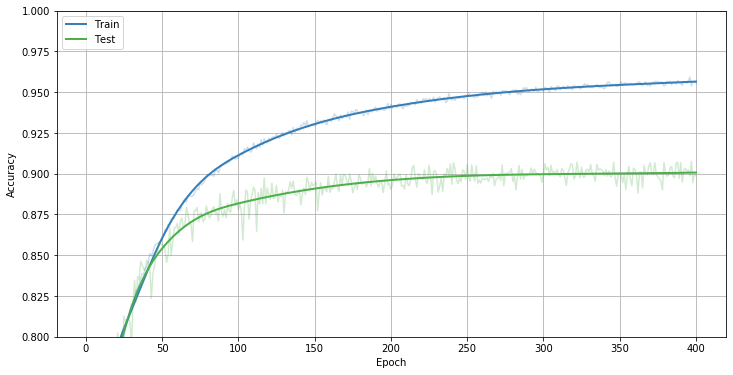

In [79]:
from scipy.interpolate import UnivariateSpline

f = plt.figure(figsize=(12,6))

x = range(1, 401)
y1 = history.history['accuracy']
y2 = history.history['val_accuracy']

xs = np.linspace(1, 400, 1000)
y1s = UnivariateSpline(x, y1, s=0.01)(xs)
y2s = UnivariateSpline(x, y2, s=0.02)(xs)

plt.plot(xs, y1s, color='#377eb8', linewidth=2.0)
plt.plot(xs, y2s, color='#4daf4a', linewidth=2.0)
plt.plot(x, y1, color='#377eb840')
plt.plot(x, y2, color='#4daf4a40')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim(0.8, 1)
plt.grid()
plt.show()


#f.savefig('90.71_2h_batch64_epoch200_2x32_2x64_3x128_3x256_512_l24e-4.svg', bbox_inches='tight')

In [95]:
model.save_weights('90.71_4h_batch64_epoch200_[cnv_32x2_64x2_128x3_256x3]_dns[512]_(l2_4e-4).h5')

In [31]:
model.load_weights('89.96_2h_batch64_epoch200_[cnv_32x2_64x2_128x2_256x2]_dns[512]_(progressive_dropout_except_before_pooling).h5')

In [97]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('data/test',
                                                   target_size=(32, 32),
                                                   batch_size=64,
                                                   shuffle=False)

Found 300000 images belonging to 1 classes.


In [98]:
pred=model.predict_generator(test_generator, steps=len(test_generator), verbose=1)

4688/4688 [==============================] - 319s 68ms/step


In [103]:
indices = np.argmax(pred, axis=1)
ids = [int(re.sub('\D+', '', name)) for name in test_generator.filenames]
flipped = {v:k for k,v in validation_generator.class_indices.items()}
labels = [flipped[i] for i in indices]
submission = pd.DataFrame({'id':ids, 'label':labels}).sort_values(['id']).reset_index(drop=True)

In [106]:
submission.to_csv('submission.csv', index=False)

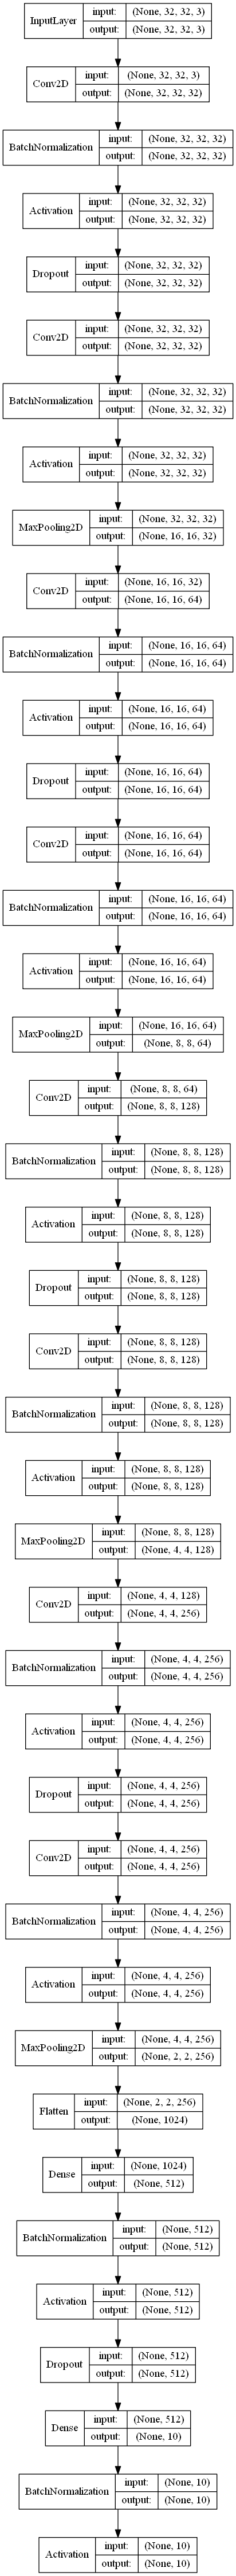

In [13]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_layer_names=False, show_shapes=True)

#### 2x32_2x64_2x128_2x256_512
31s per epoch
* 88% - 42 min
* 89% - 55 min

#### 2x32_2x64_3x128_3x256_512
36s per epoch
* 88% - 51 min
* 89% - 1.2 h
* 90% - 1.8 h

#### l2 regularization 1e-4 --> 4e-4
36s per epoch
* 88% - 50 min
* 89% -  1  h
* 90% - 1.7 h
